In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.9 MB/s eta 0:00:00


Importing dependencies


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
from transformers import AutoTokenizer
from datasets import Dataset
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Loading the dataset and displaying a wordcloud to show the most abundant words

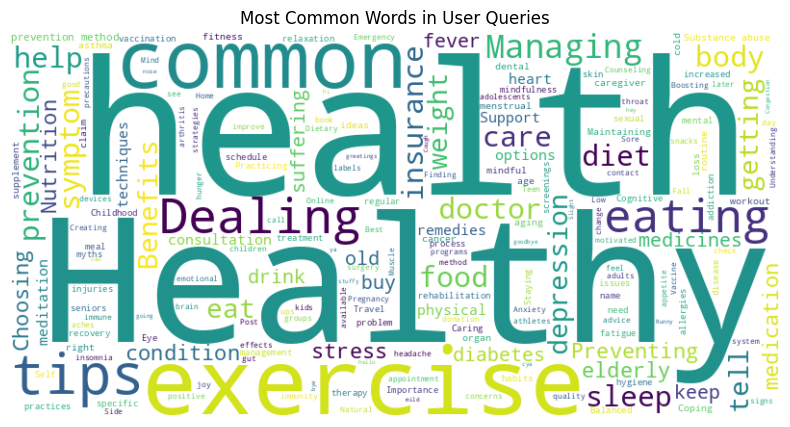

In [8]:
# Load intent data
with open("/content/data.json", "r") as file:
    data = json.load(file)

# Collect all user texts
user_texts = [text for intent in data["intents"] for text in intent["text"]]
all_text = " ".join(user_texts)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in User Queries")
plt.show()


Filter the dataset to create question answer pairs

In [6]:
# Prepare conversation pairs
conversations = []
for intent in data["intents"]:
    for text in intent["text"]:
        response = random.choice(intent["responses"])
        conversations.append(f"User: {text}\nBot: {response}")

conversations[3]

'User: good day\nBot: hello'

Loading the tokenizer and converting our dataset to a compatible hugging face dataset

In [9]:
# Load GPT-2 tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set padding token explicitly
tokenizer.pad_token = tokenizer.eos_token

# Tokenize conversation data
tokenized_data = tokenizer(conversations, padding=True, truncation=True, return_tensors="pt")

# Convert tokenized data into a Hugging Face Dataset
dataset = Dataset.from_dict({
    "input_ids": tokenized_data["input_ids"],
    "attention_mask": tokenized_data["attention_mask"]
})

print(dataset[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'input_ids': [12982, 25, 23748, 198, 20630, 25, 644, 460, 1312, 466, 329, 345, 30, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 

loading the model and setting up the training parameters

In [10]:
import torch
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset

import os
os.environ["WANDB_DISABLED"] = "true"

model = AutoModelForCausalLM.from_pretrained("gpt2")

tokenized_data = tokenizer(conversations, padding=True, truncation=True, return_tensors="pt")

training_args = TrainingArguments(
    output_dir="./chatbot_model",
    per_device_train_batch_size=2,
    num_train_epochs=1,
    save_steps=500,
    save_total_limit=2,
    logging_dir="./logs",
    report_to="none"
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)



model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [11]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


TrainOutput(global_step=174, training_loss=2.375469690081717, metrics={'train_runtime': 1037.7054, 'train_samples_per_second': 0.335, 'train_steps_per_second': 0.168, 'total_flos': 24508376064000.0, 'train_loss': 2.375469690081717, 'epoch': 1.0})

we created a second model but tuning hyperparameters to see if we can improve training and the model in general

In [12]:
training_args_2 = TrainingArguments(
    output_dir="./chatbot_model2",
    per_device_train_batch_size=3,
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=3,
    logging_dir="./logs",
    report_to="none"
)

trainer_2 = Trainer(
    model=model,
    args=training_args_2,
    train_dataset=dataset,
    data_collator=data_collator,
)

In [13]:
trainer_2.train()

Step,Training Loss


TrainOutput(global_step=348, training_loss=0.9971531835095636, metrics={'train_runtime': 2694.2253, 'train_samples_per_second': 0.387, 'train_steps_per_second': 0.129, 'total_flos': 73525128192000.0, 'train_loss': 0.9971531835095636, 'epoch': 3.0})

In [17]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_1 = AutoModelForCausalLM.from_pretrained("/content/chatbot_model/checkpoint-174")
model_2 = AutoModelForCausalLM.from_pretrained("/content/chatbot_model2/checkpoint-348")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def generate_response(model, tokenizer, prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    attention_mask = torch.ones(input_ids.shape, device=input_ids.device)

    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=50,
        temperature=0.7,
        top_k=50,
        top_p=0.9,
        repetition_penalty=1.2,
        no_repeat_ngram_size=4,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    # Decode the generated output and return it
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [18]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=b5609218acba0599e3d8ea774e4390f9c3e5e124eb643093a1073cd29d9954d3
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [19]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.metrics import f1_score

scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)

def compute_f1(reference, candidate):
    ref_tokens = reference.split()
    cand_tokens = candidate.split()
    common = set(ref_tokens) & set(cand_tokens)

    precision = len(common) / len(cand_tokens) if cand_tokens else 0
    recall = len(common) / len(ref_tokens) if ref_tokens else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0
    return f1

# Test data
test_data = [
    {"input": "Self-care ideas", "expected": "Self-care can include reading, taking walks, or practicing hobbies."},
    {"input": "Sexual health screenings", "expected": "Regular sexual health screenings are important for early detection of infections and diseases."},
]

# Evaluate for both models
for model_num, model in enumerate([model_1, model_2], start=1):
    print(f"\nEvaluating Model {model_num}...\n")

    for sample in test_data:
        # Generate model response
        sample["generated"] = generate_response(model, tokenizer, sample["input"])

        # Compute BLEU
        reference = [sample["expected"].split()]  # List of references
        candidate = sample["generated"].split()   # Model-generated response
        sample["bleu"] = sentence_bleu(reference, candidate)

        # Compute ROUGE
        scores = scorer.score(sample["expected"], sample["generated"])
        sample["rouge1"] = scores["rouge1"].fmeasure
        sample["rougeL"] = scores["rougeL"].fmeasure

        # Compute F1 score
        sample["f1"] = compute_f1(sample["expected"], sample["generated"])

        # Print results
        print(f"Prompt: {sample['input']}")
        print(f"Expected: {sample['expected']}")
        print(f"Generated: {sample['generated']}")
        print(f"BLEU: {sample['bleu']:.4f}, ROUGE-1: {sample['rouge1']:.4f}, ROUGE-L: {sample['rougeL']:.4f}, F1: {sample['f1']:.4f}\n")



Evaluating Model 1...



/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Prompt: Self-care ideas
Expected: Self-care can include reading, taking walks, or practicing hobbies.
Generated: Self-care ideas
Bot: It seems that you are suffering from depression. Please seek help for your symptoms by talking to a mental health professional or visiting an online support group like Mental Health Resource Center (MHRC). Common issues include anxiety, insomnia
BLEU: 0.0000, ROUGE-1: 0.1538, ROUGE-L: 0.1154, F1: 0.1200

Prompt: Sexual health screenings
Expected: Regular sexual health screenings are important for early detection of infections and diseases.
Generated: Sexual health screenings include mammograms, Pap smears, and blood tests. Women should consult a healthcare provider for specific advice about breast-feeding or breastfeeding options; follow up regularly to make sure you're getting the best possible care from your doctor's office
BLEU: 0.0000, ROUGE-1: 0.1786, ROUGE-L: 0.1429, F1: 0.1509


Evaluating Model 2...

Prompt: Self-care ideas
Expected: Self-care ca

In [ ]:
import shutil
from google.colab import files

# Replace 'chatbot_model' with your folder name
shutil.make_archive("chatbot_model", 'zip', "chatbot_model")

# Download the zip file
files.download("chatbot_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r chatbot_model /content/drive/MyDrive/